# Training Experiments

In [1]:
import os
import sys
import json
from pathlib import Path

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns

repo_path = os.getenv("REPO_PATH") or os.path.abspath("..")
sys.path.append(os.path.join(repo_path, "src"))

from utils import set_seed
from model import IVSurfaceMLP, IVSurfaceModelConfig
from train import (
    TrainingConfig,
    build_dataset_from_df,
    train,
    evaluate,
)
from visualize import plot_volatility_surface_3d, plot_volatility_smile, plot_term_structure

set_seed(42)
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_context("talk", font_scale=0.9)


## 1. load processed data

In [2]:
processed_dir = os.getenv("PROCESSED_DIR") or os.path.join(repo_path, "data", "processed")
ticker = os.getenv("TICKER_NAME", "SPY")
date = os.getenv("TRADE_DATE", "2023-01-03").replace("-", "")

train_path = Path(processed_dir) / f"{ticker}_{date}_train.parquet"
val_path = Path(processed_dir) / f"{ticker}_{date}_test.parquet"

if not train_path.exists():
    raise FileNotFoundError(f"Missing train file: {train_path}")
if not val_path.exists():
    raise FileNotFoundError(f"Missing val file: {val_path}")

train_df = pd.read_parquet(train_path)
val_df = pd.read_parquet(val_path)

print(f"Train shape: {train_df.shape}, Val shape: {val_df.shape}")
train_df.head()


Train shape: (3402, 42), Val shape: (851, 42)


,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,q,moneyness,log_moneyness,computed_iv,forward_moneyness,sqrt_T,log_T,is_atm,is_otm,is_itm
0,109820.0,2023-01-03,SPY 230110P369000,1,2023-01-10,2023-01-03,P,369000.0,0.72,0.73,...,0.000000,0.968962,-0.03153,0.209353,0.968218,0.138485,-3.953987,1,0,0
1,109820.0,2023-01-03,SPY 230331C447000,1,2023-03-31,2023-01-03,C,447000.0,0.54,0.56,...,0.019625,1.173783,0.160232,0.178767,1.167022,0.488217,-1.433989,0,1,0
2,109820.0,2023-01-03,SPY 230331C413000,1,2023-03-31,2023-01-03,C,413000.0,4.53,4.58,...,0.019625,1.084502,0.081121,0.194735,1.078255,0.488217,-1.433989,0,1,0
3,109820.0,2023-01-03,SPY 230331P427000,1,2023-03-31,2022-12-28,P,427000.0,45.9,46.29,...,0.019625,1.121265,0.114457,0.199224,1.114806,0.488217,-1.433989,0,0,1
4,109820.0,2023-01-03,SPY 230113P450000,1,2023-01-13,2022-12-20,P,450000.0,68.79,69.06,...,0.000000,1.181661,0.166921,0.485702,1.180365,0.165521,-3.597312,0,0,1


In [3]:
print(train_df.describe()[["mid_price", "computed_iv", "log_moneyness", "T"]])
print("\nMoneyness range:", (train_df["moneyness"].min(), train_df["moneyness"].max()))
print("Maturity range (years):", (train_df["T"].min(), train_df["T"].max()))


       mid_price  computed_iv  log_moneyness            T
count     3402.0  3402.000000         3402.0  3402.000000
mean   27.878808     0.267984      -0.010143     0.338153
min        0.015     0.158195      -0.343905     0.019178
25%       3.0625     0.215206      -0.101685     0.046575
50%       17.925     0.248396      -0.003473     0.123288
75%     43.94125     0.292128       0.085952     0.487671
max        134.5     0.951738       0.262231     1.964384
std    29.456453     0.081080       0.132357     0.423332

Moneyness range: (np.float64(0.7089963762407436), np.float64(1.2998266897746966))
Maturity range (years): (np.float64(0.019178082191780823), np.float64(1.9643835616438357))


## 2. Build Dataset & DataLoader

In [4]:
config = TrainingConfig(
    epochs=100,
    learning_rate=1e-3,
    weight_decay=1e-6,
    batch_size=256,
    log_every=5,
    val_every=5,
    lr_step_size=0,
    lr_gamma=0.5,
    lambda_calendar=0.0,
    lambda_butterfly=0.0,
    strike_bucket=0.5,
    maturity_bucket_days=7,
    min_points_per_bucket=3,
    checkpoint_path=os.path.join(repo_path, "models", f"{ticker}_{date}_ivsurface.pt"),
    device=None,
)

In [5]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from train import IVPriceDataset

def build_dataset_from_df_safe(df, cfg):
    df_num = df.copy()
    numeric_cols = list(cfg.input_cols) + ["K", "T", "r", "q", "S", cfg.target_col]
    for c in numeric_cols:
        if c in df_num.columns:
            df_num[c] = pd.to_numeric(df_num[c], errors="coerce")
    df_num = df_num.dropna(subset=list(cfg.input_cols) + ["K", "T", "r", cfg.target_col])

    features = torch.tensor(df_num[list(cfg.input_cols)].to_numpy(dtype=np.float32))
    prices = torch.tensor(df_num[cfg.target_col].to_numpy(dtype=np.float32))
    strikes = torch.tensor(df_num["K"].to_numpy(dtype=np.float32))
    maturities = torch.tensor(df_num["T"].to_numpy(dtype=np.float32))
    rates = torch.tensor(df_num["r"].to_numpy(dtype=np.float32))
    dividends = torch.tensor(df_num["q"].to_numpy(dtype=np.float32)) if "q" in df_num else torch.zeros(len(df_num))
    cp_map = {"C": 1.0, "P": -1.0}
    cp_flags = torch.tensor([cp_map.get(v, 1.0) for v in df_num["cp_flag"]], dtype=torch.float32)
    spots = torch.tensor(df_num["S"].to_numpy(dtype=np.float32)) if "S" in df_num else torch.full((len(df_num),), float(cfg.spot_constant or 0.0))
    return IVPriceDataset(
        features=features,
        prices=prices,
        strikes=strikes,
        maturities=maturities,
        rates=rates,
        dividends=dividends,
        cp_flags=cp_flags,
        spots=spots,
    )

# Rebuild datasets/loaders using the safe helper
train_ds = build_dataset_from_df_safe(train_df, config)
val_ds   = build_dataset_from_df_safe(val_df, config)
train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=config.batch_size)


## 3. Model Init

In [6]:
model_cfg = IVSurfaceModelConfig(
    input_dim=2,
    hidden_dims=(128, 128, 64),
    activation="silu",
    dropout=0.05,
    output_activation="softplus",
    min_sigma=1e-4,
    max_sigma=5.0,
    weight_init="xavier",
)

model = IVSurfaceMLP(model_cfg)
print(model)
print("Param count:", model.parameter_count())


IVSurfaceMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): SiLU()
    (2): Dropout(p=0.05, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): SiLU()
    (5): Dropout(p=0.05, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SiLU()
    (8): Dropout(p=0.05, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)
Param count: 25217


## 4. Training & Validation

In [7]:
metrics = train(
    model,
    train_data=train_ds,
    val_data=val_ds,
    config=config,
)

print("\nFinal metrics:", json.dumps(metrics, indent=2))


[Epoch 0001] train_loss=702.300688 price=702.300688 constraint=0.000000 | val_loss=206.043802 price=206.043802 constraint=0.000000
[Epoch 0005] train_loss=57.907029 price=57.907029 constraint=0.000000 | val_loss=52.511550 price=52.511550 constraint=0.000000
[Epoch 0010] train_loss=15.363166 price=15.363166 constraint=0.000000 | val_loss=11.622889 price=11.622889 constraint=0.000000
[Epoch 0015] train_loss=2.506742 price=2.506742 constraint=0.000000 | val_loss=2.821953 price=2.821953 constraint=0.000000
[Epoch 0020] train_loss=2.375949 price=2.375949 constraint=0.000000 | val_loss=2.670736 price=2.670736 constraint=0.000000
[Epoch 0025] train_loss=2.226918 price=2.226918 constraint=0.000000 | val_loss=2.553666 price=2.553666 constraint=0.000000
[Epoch 0030] train_loss=2.137196 price=2.137196 constraint=0.000000 | val_loss=2.478777 price=2.478777 constraint=0.000000
[Epoch 0035] train_loss=2.125273 price=2.125273 constraint=0.000000 | val_loss=2.420549 price=2.420549 constraint=0.000000


In [8]:
device = torch.device(config.device or ("cuda" if torch.cuda.is_available() else "cpu"))
model.to(device)

IVSurfaceMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): SiLU()
    (2): Dropout(p=0.05, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): SiLU()
    (5): Dropout(p=0.05, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SiLU()
    (8): Dropout(p=0.05, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [9]:
from pinn_constraints import ConstraintConfig

constraint_cfg = ConstraintConfig(
    strike_bucket=config.strike_bucket,
    maturity_bucket_days=config.maturity_bucket_days,
    min_points_per_bucket=config.min_points_per_bucket,
    lambda_calendar=config.lambda_calendar,
    lambda_butterfly=config.lambda_butterfly,
)

val_metrics = evaluate(
    model,
    val_loader,
    device=device,
    constraint_cfg=constraint_cfg,
    lambda_calendar=config.lambda_calendar,
    lambda_butterfly=config.lambda_butterfly,
)

print("Val metrics:", json.dumps(val_metrics, indent=2))


Val metrics: {
  "loss": 2.0964613218565247,
  "price_loss": 2.0964613218565247,
  "constraint_loss": 0.0
}


## 5. Visualize

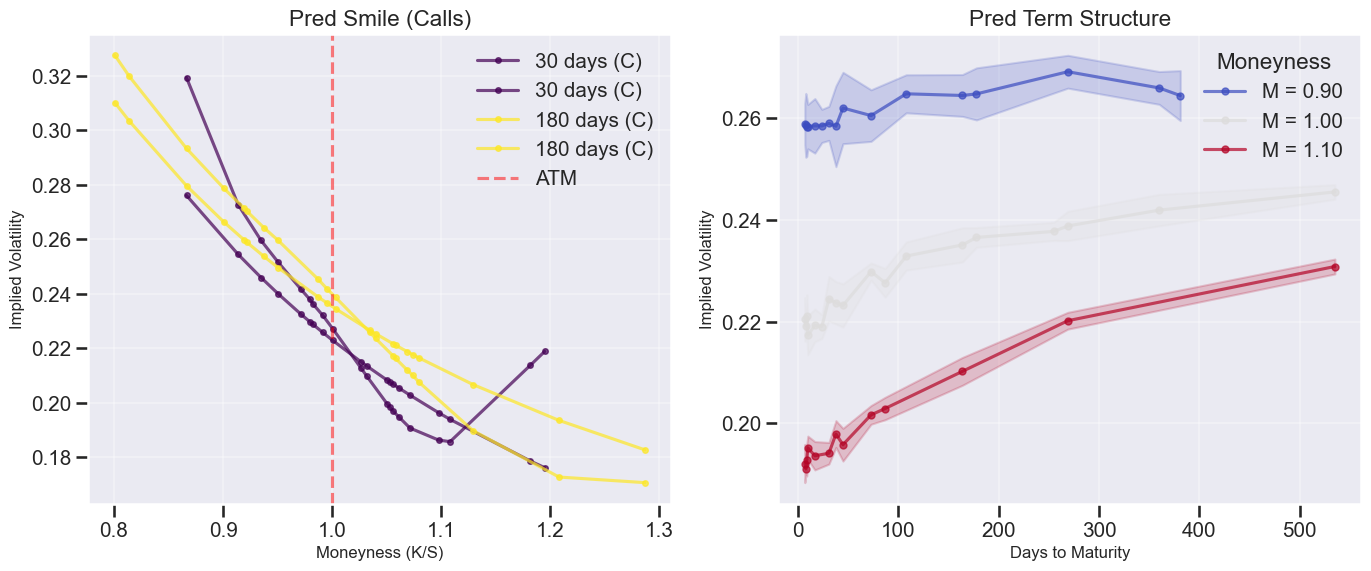

In [10]:
sample = val_df.sample(min(2000, len(val_df)), random_state=42).reset_index(drop=True)

# ensure numeric and drop any NaNs
sample[["log_moneyness", "T"]] = (
    sample[["log_moneyness", "T"]].apply(pd.to_numeric, errors="coerce").astype(np.float32)
)
sample = sample.dropna(subset=["log_moneyness", "T"]).reset_index(drop=True)

x_tensor = torch.tensor(sample[["log_moneyness", "T"]].to_numpy(), dtype=torch.float32).to(device)
with torch.no_grad():
    sigma_pred = model(x_tensor).cpu().numpy().flatten()

sample["sigma_pred"] = sigma_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_volatility_smile(sample.rename(columns={"sigma_pred": "computed_iv"}), [30, 60, 90, 180], option_type="C", ax=axes[0])
axes[0].set_title("Pred Smile (Calls)")

plot_term_structure(sample, iv_col="sigma_pred", moneyness_levels=[0.9, 1.0, 1.1], ax=axes[1])
axes[1].set_title("Pred Term Structure")

plt.tight_layout()
plt.show()


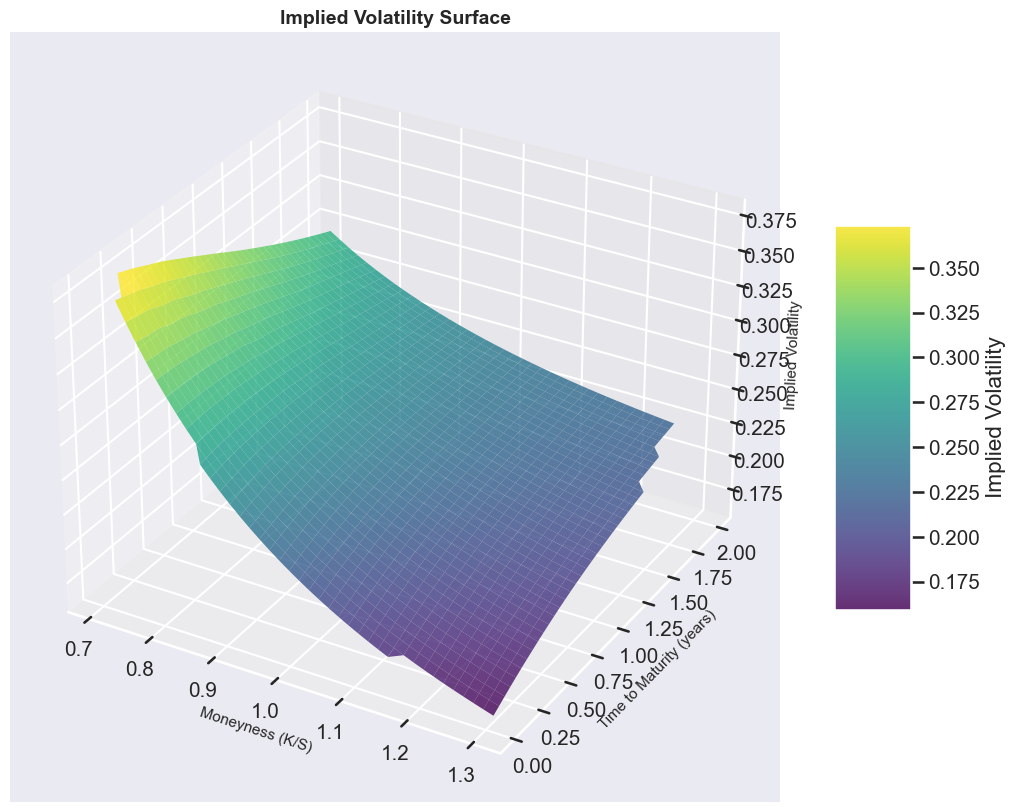

In [11]:
fig = plot_volatility_surface_3d(
    sample, iv_col="sigma_pred", interpolate=True, grid_size=40
)
plt.show()


## 6. Save & Config

In [12]:
os.makedirs(os.path.dirname(config.checkpoint_path), exist_ok=True)
torch.save(model.state_dict(), config.checkpoint_path)

cfg_out = {
    "training_config": config.__dict__,
    "model_config": model_cfg.__dict__,
    "ticker": ticker,
    "date": date,
}
cfg_path = Path(config.checkpoint_path).with_suffix(".json")
with open(cfg_path, "w") as f:
    json.dump(cfg_out, f, indent=2)

print("Saved checkpoint to:", config.checkpoint_path)
print("Saved config to:", cfg_path)


Saved checkpoint to: /Users/alex/Desktop/inverse-iv-surface-pinn/models/SPY_20230103_ivsurface.pt
Saved config to: /Users/alex/Desktop/inverse-iv-surface-pinn/models/SPY_20230103_ivsurface.json
